In [1]:
# Required Packages
import pandas as pd
import numpy as np

import unicodedata

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## missingno
import missingno as msno

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px
# Graphics in retina format 
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore")

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/1280px-IMDB_Logo_2016.svg.png' width ='300' align="center"/>

<div class="alert alert-block alert-success">
<font size="+2"><b>IMDB Movie Dataset</b></font>
</div>

# Preprocessing

In this article, we use an IMDB movie dataset from Kaggle.com. The object of the exercise is to recommend similar movies to a given movie. In the [first part](https://hatefdastour.github.io/portfolio/natural_language_processing/Movie_Recommendation_system_Preprocessing.html) of this article, we have applied several preprocessing methods to clean the data.

#### Table of contents
* [Initial Analysis](#Initial-Analysis)
* [Modeling](#Modeling)
* [Movie Recommendations](#Movie-Recommendations)


#### Loading the Data

In [2]:
Data = pd.read_csv('movie_metadata/clean_movie_metadata.csv')
Data.head().style.hide_index()

## Initial Analysis

The columns of the dataset:

In [3]:
Columns = Data.columns.tolist()
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Columns:'+ Style.RESET_ALL + ' %s' % ', '.join(Columns))

Columns: Movie_Title, Actor_1_Facebook_Likes, Actor_1_Name, Actor_2_Facebook_Likes, Actor_2_Name, Actor_3_Facebook_Likes, Actor_3_Name, Budget, Cast_Total_Facebook_Likes, Color, Content_Rating, Country, Director_Facebook_Likes, Director_Name, Duration, Genres, Gross, IMDB_Score, Language, Movie_Facebook_Likes, Num_Critic_For_Reviews, Num_User_For_Reviews, Num_Voted_Users, Plot_Keywords, Title_Year


The dendrogram graph shows correlate variable completion. It also reveals trends.

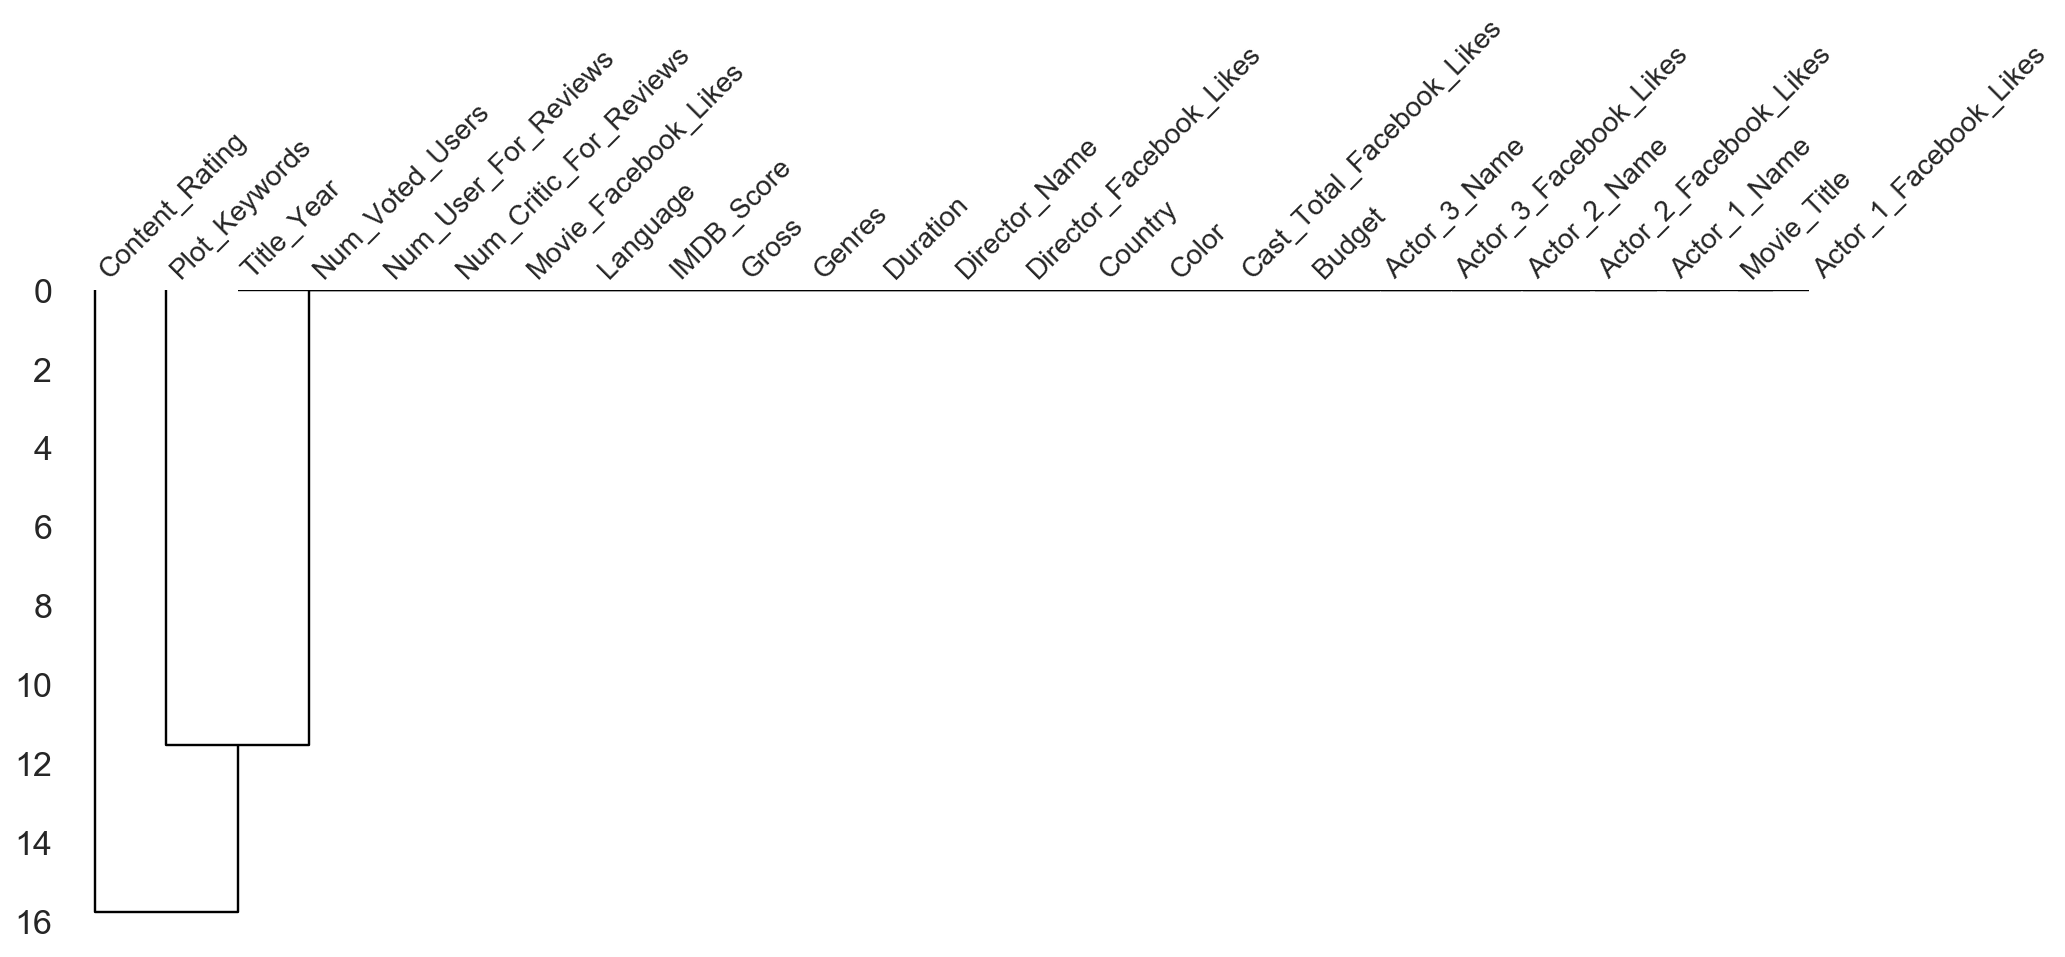

In [4]:
_ = msno.dendrogram(Data, figsize=(16,6), fontsize=14)

In [5]:
Ratings = Data[['Movie_Title','Gross','IMDB_Score','Num_Critic_For_Reviews', 'Num_User_For_Reviews']]
Ratings.sort_values(by='Gross', ascending=False).head(10).style.hide_index()

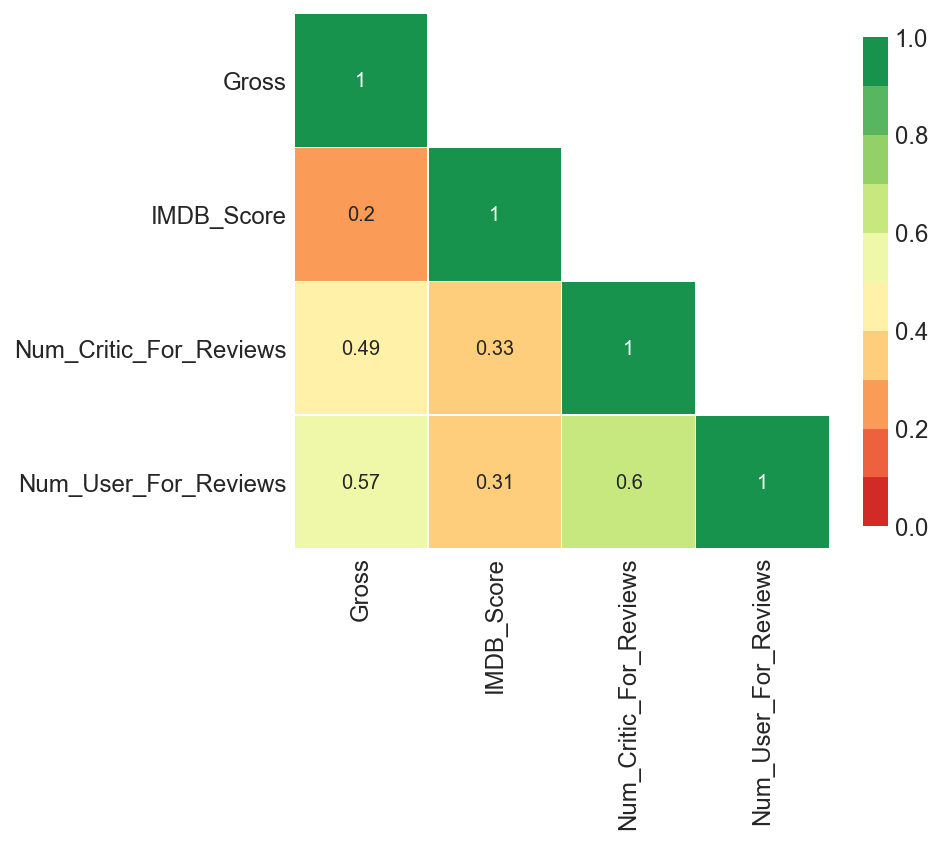

In [6]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdYlGn", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .75})
    bottom, top = ax.get_ylim()
    
Rew_col_list=['Gross','IMDB_Score','Num_Critic_For_Reviews', 'Num_User_For_Reviews']
Correlation_Plot (Ratings[Rew_col_list],6)

It can be seen that both **the number of critics for reviews** and **the number of users for reviews** are highly correlated with **gross**.

Pairplot

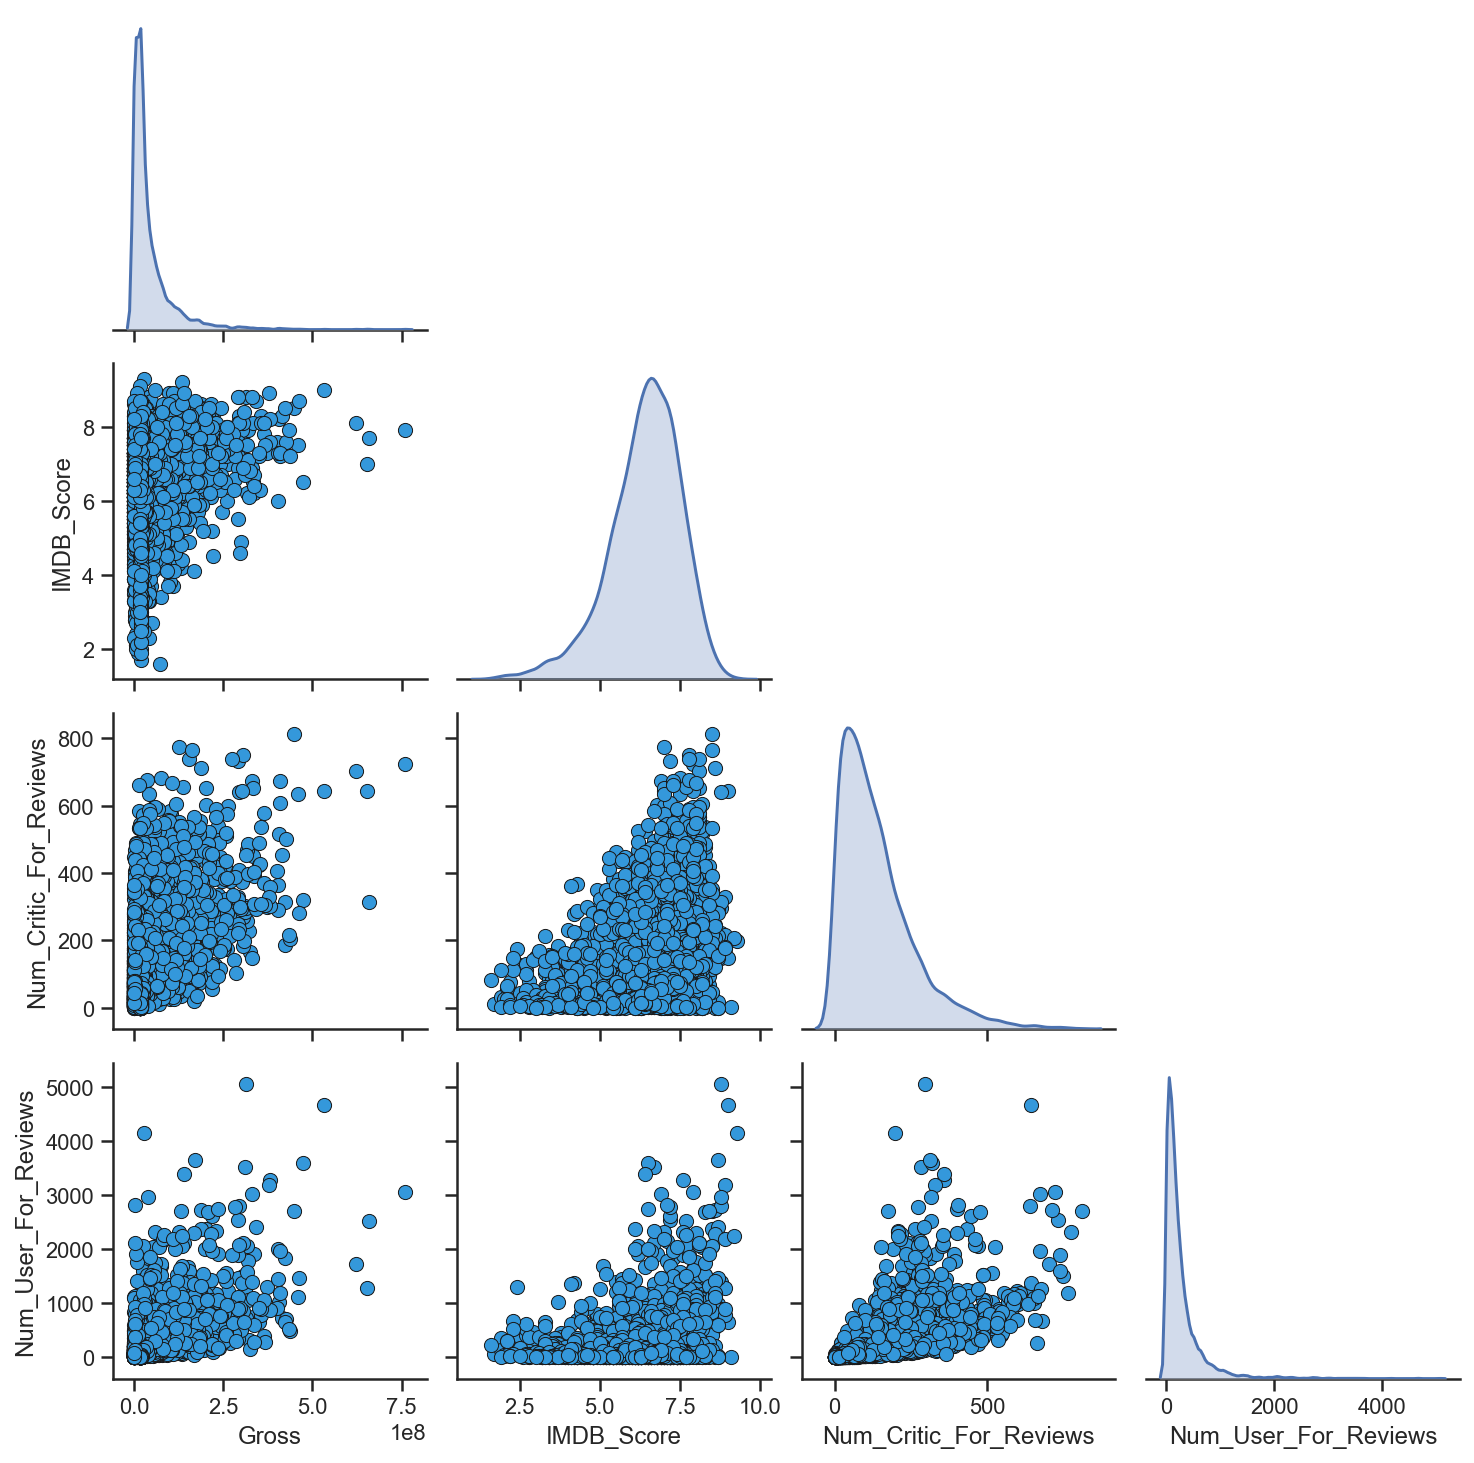

In [7]:
sns.set(style="ticks", color_codes=True)
_ = sns.pairplot(Ratings, height=2.5, diag_kind="kde", 
             plot_kws=dict(s=50, color="#3498db", edgecolor="k", linewidth=0.5),
             diag_kws=dict(shade=True), corner=True)

We can see that **the number of critics for reviews** and **the number of users for reviews** are highly correlated.

## Modeling

We would like to convert the data into only two columns. That is one column only the movie titles and the other one all relevant information about a movie. Since we don't have any information on users' performance. This is a way to model this data.

In [8]:
Drop_List=list()

for i in range(len(Columns)):
    if Columns[i].find('Facebook') != -1:
        Drop_List.append(Columns[i])
    if Columns[i].find('Num') != -1:
        Drop_List.append(Columns[i])
        
## Adding the rest of unrelated columns to the drop list       
Drop_List=Drop_List+['Budget','Duration','Gross','IMDB_Score']
Data=Data.drop(columns=Drop_List)

This, the date reduces to

In [9]:
Data = Data.reindex(columns=sorted(Data.columns,reverse=True))
Data.head().style.hide_index()

Converting the Data to string.

In [10]:
Data=Data.astype(str)

More modifications on `genres` anc `plot_keywords` columns:

In [11]:
### Genres
# converting to lower case
Data.Genres = Data.Genres.map(lambda x: x.lower())
# replacing '|' with ','
Data.Genres = Data.Genres.map(lambda x: x.split('|'))
# joining the string
Data.Genres = Data.Genres.str.join(' ') 

### Plot_Keywords
# converting to lower case
Data.Plot_Keywords = Data.Plot_Keywords.map(lambda x: x.lower())
# replacing '|' with ','
Data.Plot_Keywords = Data.Plot_Keywords.map(lambda x: x.split('|'))
Data.Plot_Keywords = Data.Plot_Keywords.str.join(' ') 
Data['Title_Year'] = Data['Title_Year'].astype(float).astype(int)

The resulting Data

In [12]:
Data.head().style.hide_index()

Mimicing the process for actors and directors names:

In [13]:
for i in range(len(Columns)):
    if Columns[i].find('Name') != -1:
        Data[Columns[i]] = Data[Columns[i]].map(lambda x: x.split(' '))
        Data[Columns[i]] = Data[Columns[i]].str.join('')

In [14]:
Data.head().style.hide_index()

Converting the data to two columns only, `Movie_Title` and `Other`

In [15]:
X = 'Movie_Title'
Y = list()
temp=Data.columns.tolist()
for i in range(len(temp)):
    if temp[i].find('Movie_Title') == -1:
         Y.append(temp[i])
del temp

Data['Text']=Data[Y[0]].astype(str)
for i in np.arange(1,len(Y)):
    Data['Text'] = Data['Text']+" "+ Data[Y[i]].astype(str)
del i

Droping Y columns

In [16]:
Data=Data.drop(columns=Y)
del X, Y

In [17]:
Data.head().style.hide_index()

Instantiating and generating the count matrix using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [18]:
vectorizer = CountVectorizer()
Matrix= vectorizer.fit_transform(Data['Text'])
# to view the entries run the following command
# vectorizer.get_feature_names()

Next, we are going to use [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find similarities.

In [19]:
Similarity_Matrix = cosine_similarity(Matrix, dense_output=True)
print('This is a %i by %i matrix' % Similarity_Matrix.shape)

This is a 4799 by 4799 matrix


## Movie Recommendations

In [20]:
def recommend_movies(title, Number_Of_Recommendations= 10, Sim_Matrix=Similarity_Matrix):
    # Recommended Movies List 
    Recommended_Movies_List  = []
    
    # the index of 'title' from the dataframe
    title_index = Data[Data['Movie_Title'].str.match(title)].index[0]
    
    # 'title' matches in descending order
    Title_Matches = pd.Series(Sim_Matrix[title_index]).sort_values(ascending = False)

    # Picking Number_Of_Recommendations movies
    Recom_index = list(Title_Matches.iloc[1:Number_Of_Recommendations].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in Recom_index:
        Recommended_Movies_List.append(list(Data.Movie_Title)[i].replace(u'\xa0', u''))
    
    Recommended_Movies_List=pd.DataFrame(Recommended_Movies_List,
                                         columns=['Recommended Titles']).style.hide_index()    
    return Recommended_Movies_List

For example, consider **The Dark Knight**. For this movie, the following ten movies are recommended.

In [21]:
recommend_movies('The Dark Knight Rises')

***